In [35]:
# libraries
import logging
import os
import re
# import pprint
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import random


In [2]:
# logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Document variable
data_size = 'large'

assert data_size in ['small', 'medium', 'large'], "data_size should be one of ['small', 'medium', 'large']"

data_path = '../local_data/_' + data_size + '_data2.csv' # read "../local_data/_medium_data.csv"

## Read Data

In [4]:
# read data
df = pd.read_csv(data_path)
df = df[['index', 'job_name', 'job_index', 'tokenized_text', 'en_prob']]
df.head()

,index,job_name,job_index,tokenized_text,en_prob
0,0,Accountant,0,"['sfd', 'professional', 'corporation', 'is', '...",1.0
1,1,Accountant,1,"['job', 'no', 'brand', 'flight', 'centre', 'tr...",1.0
2,2,Accountant,2,"['future', 'you', 'want', 'is', 'within', 'rea...",1.0
3,3,Accountant,3,"['junior', 'accountant', 'an', 'enthusiastic',...",1.0
4,4,Accountant,4,"['az', 'accounting', 'firm', 'is', 'profession...",1.0


### Filter Data

In [5]:
# print percentage of records kept by threshold of `en_prob` column (probably of column content being english)
for threshold in np.arange(0.1, 1.01, 0.1):
  r_count = df.shape[0]
  mask = df['en_prob'] >= threshold
  percentage = round(sum(mask) / r_count, 4)
  print("Threshold : {}, Percentage of records : {}".format(round(threshold, 2), round(percentage * 100, 2)))

Threshold : 0.1, Percentage of records : 91.59
Threshold : 0.2, Percentage of records : 91.13
Threshold : 0.3, Percentage of records : 90.72
Threshold : 0.4, Percentage of records : 90.72
Threshold : 0.5, Percentage of records : 90.41
Threshold : 0.6, Percentage of records : 90.17
Threshold : 0.7, Percentage of records : 90.17
Threshold : 0.8, Percentage of records : 90.0
Threshold : 0.9, Percentage of records : 89.69
Threshold : 1.0, Percentage of records : 89.69


In [6]:
# Use job descriptions using engligh only:
en_prob_mask = df['en_prob'] >= 0.9
df_eng = df[en_prob_mask]

In [7]:
# data scientist jobs are included 4x the amount. Only keeping 1/4 of them
less_ds_mask = ~((df_eng['job_name'] == "Data Scientist") & (df_eng['job_index'] > 25))
df_less_ds = df_eng[less_ds_mask]
df_less_ds.shape[0]

119127

In [8]:
# Only use jobs with 50+ postings
value_counts = df_less_ds['job_name'].value_counts()

jobs_50_count = value_counts[value_counts > 50].index
jobs_mask = df_less_ds['job_name'].isin(list(jobs_50_count))

df_jobs = df_less_ds[jobs_mask]
df_jobs['job_name'].value_counts()

job_name
Administrator             2454
Administration Manager    2451
Accountant                2432
Administration Staff      2355
Accounts Manager          2348
                          ... 
Homeopath                   68
Reprographic Assistant      60
Maths Teacher               56
Cartographer                55
Horse Dealer                55
Name: count, Length: 162, dtype: int64

### Split data for training/test

In [9]:
# Split training / test data:
X = df_jobs.drop(columns=['job_name'])
y = df_jobs['job_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

In [10]:
# Function to convert raw list back to tokens
def raw_tokens_to_tokens(text):
  subbed = re.sub(r"[\[\],']", "", text)
  split = subbed.split(" ")
  return split

### Create Corpus

In [11]:
processed_corpus = [raw_tokens_to_tokens(text) for text in X_train['tokenized_text']]

In [12]:
# Function to create taggedDocument from tokenized documents
def create_tagged_doc(processed_corpus, indexes):
    for tokens, index in zip(processed_corpus, indexes):
        yield gensim.models.doc2vec.TaggedDocument(tokens, [index])

In [13]:
train_corpus = list(create_tagged_doc(processed_corpus, X_train['index']))

In [14]:
len(train_corpus)

94910

In [15]:
# validate tag = index match of few records:
i = 173
corpus_record = train_corpus[i]
record_tag = corpus_record[1][0]

mask = X_train['index'] == record_tag
df_record = X_train[mask]['tokenized_text'].values[0]

print(corpus_record[0])
print(df_record)

['commissioning', 'engineer', 'contact', 'us', 'apply', 'this', 'job', 'job', 'information', 'reference', 'number', 'job', 'function', 'project', 'product', 'management', 'position', 'type', 'full', 'time', 'site', 'richmond', 'viking', 'way', 'richmond', 'bc', 'gea', 'heating', 'refrigeration', 'technologies', 'is', 'global', 'specialist', 'industrial', 'refrigeration', 'heating', 'sustainable', 'energy', 'solutions', 'wide', 'array', 'industries', 'including', 'food', 'beverage', 'dairy', 'oil', 'gas', 'we', 'offer', 'interesting', 'challenging', 'tasks', 'positive', 'working', 'environment', 'international', 'teams', 'opportunities', 'personal', 'development', 'growth', 'global', 'company', 'your', 'tasks', 'commissioning', 'engineer', 'is', 'responsible', 'starting', 'up', 'geas', 'freezer', 'equipment', 'line', 'meet', 'design', 'contract', 'includes', 'planning', 'coordination', 'site', 'visits', 'with', 'project', 'manager', 'project', 'team', 'members', 'customer', 'commissioni

## Train Model

In [16]:
# initiate model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

2024-03-30 09:53:11,410 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d100,n5,w5,mc2,s0.001,t3>', 'datetime': '2024-03-30T09:53:11.410331', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [17]:
# build vocabulary
model.build_vocab(train_corpus)

2024-03-30 09:53:11,443 : INFO : collecting all words and their counts
2024-03-30 09:53:11,444 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-03-30 09:53:12,010 : INFO : PROGRESS: at example #10000, processed 4151958 words (7345149 words/s), 35412 word types, 0 tags
2024-03-30 09:53:12,614 : INFO : PROGRESS: at example #20000, processed 8276326 words (6845093 words/s), 44468 word types, 0 tags
2024-03-30 09:53:13,199 : INFO : PROGRESS: at example #30000, processed 12358696 words (6976732 words/s), 49688 word types, 0 tags
2024-03-30 09:53:13,779 : INFO : PROGRESS: at example #40000, processed 16474834 words (7111794 words/s), 53363 word types, 0 tags
2024-03-30 09:53:14,366 : INFO : PROGRESS: at example #50000, processed 20588023 words (7019455 words/s), 56182 word types, 0 tags
2024-03-30 09:53:14,947 : INFO : PROGRESS: at example #60000, processed 24684134 words (7059184 words/s), 58335 word types, 0 tags
2024-03-30 09:53:15,522 : INFO : PR

In [18]:
# Demonstration:
word = 'sql'
print(f"Word '{word}' appeared {model.wv.get_vecattr(word, 'count')} times in the training corpus.")

Word 'sql' appeared 3003 times in the training corpus.


In [19]:
model.corpus_count

94910

In [20]:
# model training
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

2024-03-30 09:53:18,041 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 57865 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2024-03-30T09:53:18.041074', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
2024-03-30 09:53:19,051 : INFO : EPOCH 0 - PROGRESS: at 3.98% examples, 1419210 words/s, in_qsize 5, out_qsize 0
2024-03-30 09:53:20,053 : INFO : EPOCH 0 - PROGRESS: at 8.22% examples, 1471949 words/s, in_qsize 5, out_qsize 0
2024-03-30 09:53:21,054 : INFO : EPOCH 0 - PROGRESS: at 12.65% examples, 1511540 words/s, in_qsize 5, out_qsize 0
2024-03-30 09:53:22,060 : INFO : EPOCH 0 - PROGRESS: at 16.91% examples, 1513525 words/s, in_qsize 5, out_qsize 0
2024-03-30 09:53:23,063 : INFO : EPOCH 0 - PROGRESS: at 21.40% examples, 1526790 words/s, in_qsize 5, out_qsize 0
2024-03-30 

In [21]:
# save model
path = '../local_models/{}_model2'.format(data_size)
model.save(path)

2024-03-30 10:08:41,109 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '../local_models/large_model2', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-03-30T10:08:41.109237', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'saving'}
2024-03-30 10:08:41,110 : INFO : storing np array 'vectors' to ../local_models/large_model2.dv.vectors.npy
2024-03-30 10:08:41,160 : INFO : not storing attribute cum_table
2024-03-30 10:08:41,243 : INFO : saved ../local_models/large_model2


### Evaluate Model via visualization

#### Training Data first

In [22]:
# Create document embedding
document_embeddings = np.array([model.infer_vector(doc) for doc in processed_corpus])
document_embeddings.shape

(94910, 100)

In [23]:
# pca + visualization

# random seed for repeatability
np.random.seed(0)

# perform PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(document_embeddings)

In [24]:
# Get label
train_corpus_tags = [document.tags[0] for document in train_corpus]

In [25]:
# create label for pca visualization
pca_label = [df_jobs[df_jobs['index'] == tag]['job_name'].values[0] for tag in train_corpus_tags]

In [26]:
# curate dataframe for pca visualization (training)
pca_data = pd.DataFrame({
  "pc_1" : principal_components[:, 0],
  "pc_2" : principal_components[:, 1],
  "pc_3" : principal_components[:, 2],
  "pc_4" : principal_components[:, 3],
  "pc_5" : principal_components[:, 4],
  "label" : pca_label
})

pca_data.shape

(94910, 6)

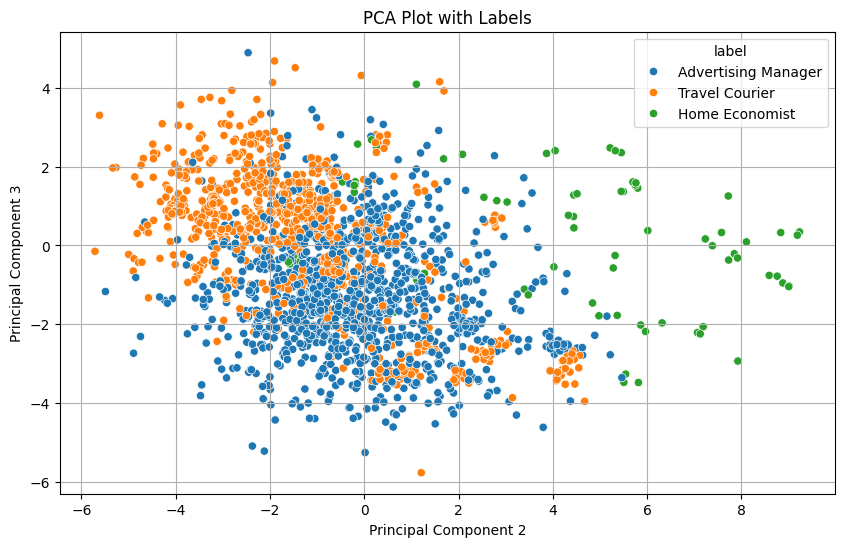

In [27]:
# visualizing training data
np.random.seed(10) # set random seed
n = 3 # number of job names to visualize
unique_jobs = pca_data['label'].unique()
jobs_to_visualize = np.random.choice(unique_jobs, size=n, replace=False)
pc_x = 2 # choose principal components to visualize
pc_y = 3 # choose principal components to visualize

# alternatively, hard code jobs to visualize:
# jobs_to_visualize = ['Research Consultant', 'Researcher', 'Horse Trainer']

# visualize PCA using seaborn
pca_mask = pca_data['label'].isin(jobs_to_visualize)
pca_show_data = pca_data[pca_mask]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc_{}'.format(pc_x), y='pc_{}'.format(pc_y), hue='label', data=pca_show_data)  # Change palette as needed
plt.title('PCA Plot with Labels')
plt.xlabel('Principal Component {}'.format(pc_x))
plt.ylabel('Principal Component {}'.format(pc_y))
plt.grid(True)
plt.show()

#### Visualize Test Data

In [28]:
# Create document for test data
processed_test_corpus = [raw_tokens_to_tokens(text) for text in X_test['tokenized_text']]
test_corpus = list(create_tagged_doc(processed_test_corpus, X_test['index']))

len(test_corpus)

23728

In [29]:
# Create document embedding
test_document_embeddings = np.array([model.infer_vector(doc.words) for doc in test_corpus])
test_document_embeddings.shape

(23728, 100)

In [30]:
# Generate Principal components for test data
test_principal_components = pca.transform(test_document_embeddings)
test_principal_components.shape

(23728, 5)

In [31]:
# Get label
train_corpus_tags = [document.tags[0] for document in test_corpus]
len(train_corpus_tags)

23728

In [32]:
# create label for pca visualization
pca_test_label = [df_jobs[df_jobs['index'] == tag]['job_name'].values[0] for tag in train_corpus_tags]
len(pca_test_label)

23728

In [33]:
# curate dataframe for pca visualization (training)
pca_test_data = pd.DataFrame({
  "pc_1" : test_principal_components[:, 0],
  "pc_2" : test_principal_components[:, 1],
  "pc_3" : test_principal_components[:, 2],
  "pc_4" : test_principal_components[:, 3],
  "pc_5" : test_principal_components[:, 4],
  "label" : pca_test_label
})

pca_test_data.shape

(23728, 6)

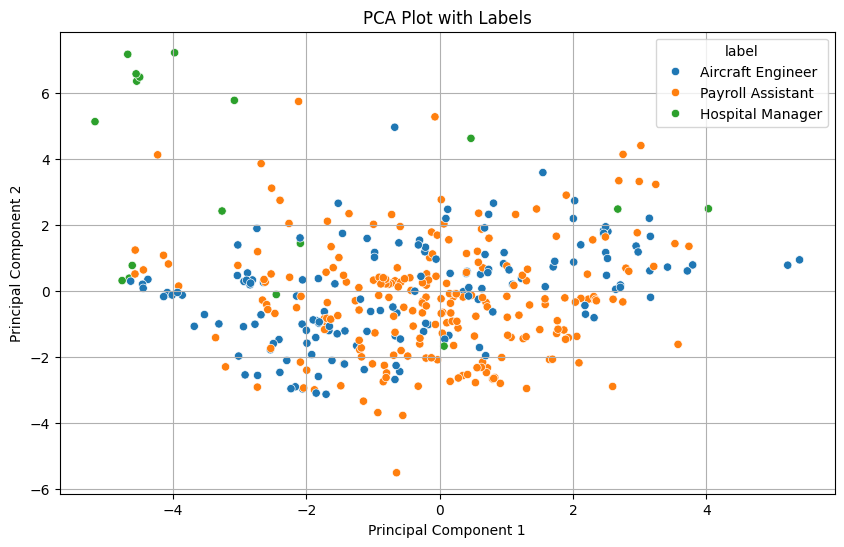

In [34]:
# visualizing test data
np.random.seed(10) # set random seed
n = 3 # number of job names to visualize
test_unique_jobs = pca_test_data['label'].unique()
test_jobs_to_visualize = np.random.choice(test_unique_jobs, size=n, replace=False)
test_pc_x = 1 # choose principal components to visualize
test_pc_y = 2 # choose principal components to visualize

# alternatively, hard code jobs to visualize:
# jobs_to_visualize = ['Research Consultant', 'Researcher', 'Horse Trainer']

# visualize PCA using seaborn
test_pca_mask = pca_test_data['label'].isin(test_jobs_to_visualize)
test_pca_show_data = pca_test_data[test_pca_mask]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc_{}'.format(test_pc_x), y='pc_{}'.format(test_pc_y), hue='label', data=test_pca_show_data)  # Change palette as needed
plt.title('PCA Plot with Labels')
plt.xlabel('Principal Component {}'.format(test_pc_x))
plt.ylabel('Principal Component {}'.format(test_pc_y))
plt.grid(True)
plt.show()

# Save Various Data

In [116]:
# Save document_embeddings
np.save("../local_data/_train_doc_embeddings.npy", document_embeddings)
np.save("../local_data/_test_doc_embeddings.npy", test_document_embeddings)

In [118]:
# Save train / test data indexes
training_index = X_train['index']
test_index = X_test['index']

np.save("../local_data/_training_data_index.npy", training_index)
np.save("../local_data/_test_data_index.npy", test_index)